# IA Practica 4: Redes Neuronales
## Hecho por: Juan Mario Sosa Romo 320051926
### v0.1 06/04/25

#### Instalación de bibliotecas

In [ ]:
!pip install tensorflow matplotlib scikit-learn pillow

import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path              # biblioteca para ayudarnos a lidiar con rutas y archivos
from PIL import Image
from sklearn.model_selection import train_test_split # nos ayuda a dividir el dataset en test y modelo
import tensorflow as tf
from tensorflow.keras import layers, models


#### Leer y conseguir imagenes

##### Conectar con drive (**PELIGRO**)

In [ ]:
## No se que tanto acceso de usar drive asi pero por favor no le des mal uso xd
from google.colab import drive
drive.mount('/content/drive')
base_dir = Path('/content/drive/MyDrive/Universidad/Semestre_VI/IA/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Pasar las imgs a algo decente

In [ ]:
data_dir = base_dir / 'brain_tumor_dataset'
yes_dir = data_dir / "yes" ## esta carpeta miente con sus nombres solo hay 155 archivos
no_dir  = data_dir / "no"  ## esta carpeta miente con el formato de sus nombres

VALID_EXT = (".jpg", ".jpeg", ".png")

def load_images_from(folder, label, size=(128, 128)):
    """Carga imágenes de una carpeta, las redimensiona y les asigna una etiqueta.

    Esta función recorre todos los archivos en una carpeta,
    carga las imágenes con las extensiones especificadas,
    las convierte a escala de grises,
    las redimensiona a un tamaño uniforme,
    normaliza los valores de los píxeles
    y las agrega a una lista junto con sus etiquetas correspondientes.

    Args:
        folder (pathlib.Path): La ruta a la carpeta que contiene las imágenes.
        label (int): La etiqueta que se asignará a las imágenes de esta carpeta. (1 para si 0 para no)
        size (tuple, optional): El tamaño deseado de la imagen (ancho, alto).
                                Por defecto es (128, 128).

    Returns:
        tuple: Una tupla que contiene dos listas:
            - images: Una lista de matrices NumPy que representan las imágenes cargadas.
            - labels: Una lista de etiquetas correspondientes a las imágenes.
    """
    images, labels = [], []
    for path in folder.rglob("*"):
        name = path.name.strip().lower()
        if any(name.endswith(ext) for ext in VALID_EXT):
            try:
                img = Image.open(path).convert("L")
                img = img.resize(size)
                arr = np.array(img, dtype=np.float32) / 255.0
                images.append(arr)
                labels.append(label)
            except Exception as e:
                print(f"Error al cargar {path}: {e}")
    return images, labels


# Cargamos ambas clases
imgs_yes, lbls_yes = load_images_from(yes_dir, 1)
imgs_no,  lbls_no  = load_images_from(no_dir,  0)

print(f"Tumor: {len(imgs_yes)} imágenes.  No tumor: {len(imgs_no)} imágenes.")


Tumor: 155 imágenes.  No tumor: 98 imágenes.


#### Mezclar datasets mantieniendo las etiquetas

In [ ]:
X = np.stack(imgs_yes + imgs_no)  # forma: (N, 128, 128)
y = np.array(lbls_yes + lbls_no)  # forma: (N,)

# Mezclamos
perm = np.random.permutation(len(X)) # esto nos da una permutacion unica para ambos
X, y = X[perm], y[perm] # aplicamos la permutacion a ambas listas

# Añadimos canal al final para Keras: (N, 128, 128, 1)
# Keras recibe algo de la forma (numero_imgs, altura, anchura, canales)
X = X[..., np.newaxis] # Imgs solo tienen grises, RGB serian 3
print("Shape X:", X.shape, "Shape y:", y.shape)


Shape X: (253, 128, 128, 1) Shape y: (253,)


#### Dividimos el dataset 80 20

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42) ## stratify asegura que si se usen tanto yes como no
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (202, 128, 128, 1) (202,)
Test: (51, 128, 128, 1) (51,)


#### Definimos nuestra red simple

In [ ]:
model = models.Sequential([
    layers.Input(shape=(128,128,1)),         # Entrada de imagenes con el tamaño que pusimos arriba
    layers.Conv2D(32, 3, activation='relu'), # Convolucional, 32 filtros 3x3 con RELU god (max(x,0))
    layers.MaxPooling2D(),                   # Agrupacion
    layers.Conv2D(64, 3, activation='relu'), # Convo con 64
    layers.MaxPooling2D(),                   # Agrupacion
    layers.Conv2D(128, 3, activation='relu'), # Convo con 128
    layers.MaxPooling2D(),                   # Agrupacion
    layers.Flatten(),
    layers.Dense(128, activation='relu'),    # Densa
    layers.Dropout(0.6),                     # Dropout para evitar overfitting
    layers.Dense(1, activation='sigmoid')    # Salida, sigmoide te da 0 o 1
])

## detalles importantes es que el tamaño del filtro basicamente es el tipo de caracteristica que puedes buscar
## las capas conv2D buscan caracteristicas con filtros, las densas combinan caracteristicas y las de agrupacion reducen la informacion

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento del modelo

In [ ]:
history = model.fit(      # fit de ajustar persos internos
    X_train, y_train,     # input data y etiquetas
    epochs=20,            # Usar muchisimas epocas no ayuda a mejorar por el overfiting
    batch_size=32,        # Ajustamos pesos tras 32 muestras
    validation_split=0.05  # 5% de validación interna, nos da datos de como va evolucionando
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 883ms/step - accuracy: 0.5466 - loss: 0.6488 - val_accuracy: 0.6364 - val_loss: 0.5476
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7062 - loss: 0.5727 - val_accuracy: 0.8182 - val_loss: 0.4522
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 822ms/step - accuracy: 0.7489 - loss: 0.5083 - val_accuracy: 0.9091 - val_loss: 0.4204
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8163 - loss: 0.4568 - val_accuracy: 0.8182 - val_loss: 0.3823
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 824ms/step - accuracy: 0.8476 - loss: 0.4061 - val_accuracy: 0.8182 - val_loss: 0.3667
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8298 - loss: 0.3764 - val_accuracy: 0.8182 - val_loss: 0.3482
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 842ms/step - accuracy: 0.8491 - loss: 0.3397 - val_accuracy: 0.8182 - val_loss: 0.3238
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8889 - loss: 0.3435 - val_accuracy: 0.8182 - val_loss: 0.3522
Epoc

#### Evaluar al modelo

##### graficas

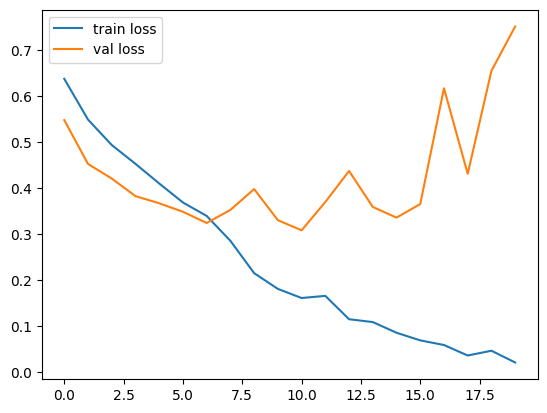

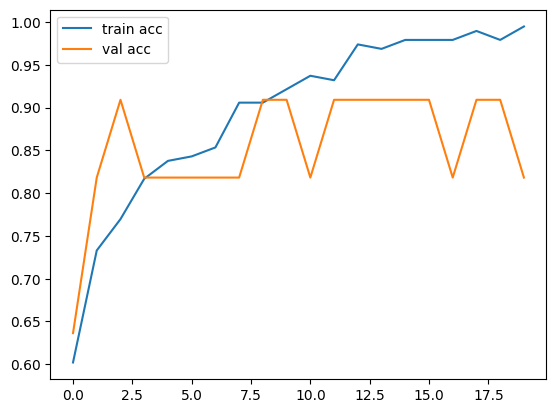

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(); plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend(); plt.show()


Podemos ver oferfiting en las etapas 12.5 en adelante pero lo deje asi porque se ve mas claro.

##### En numeros

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Pérdida en test: {test_loss:.3f}, Precisión en test: {test_acc:.3f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7545 - loss: 1.1902
Pérdida en test: 1.214, Precisión en test: 0.725


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


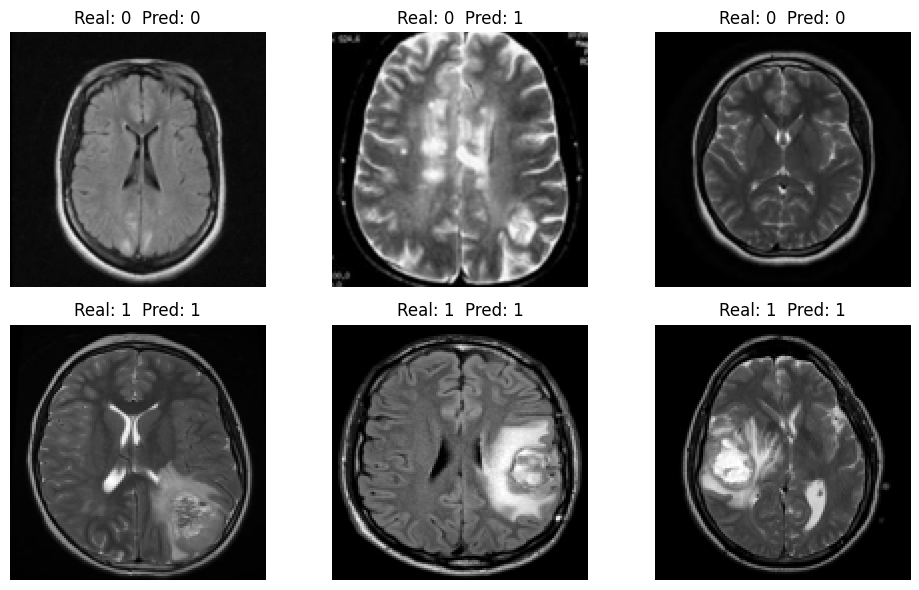

In [ ]:
idxs = np.random.choice(len(X_test), size=6, replace=False)
fig, axes = plt.subplots(2,3, figsize=(10,6))
for ax, idx in zip(axes.flatten(), idxs):
    img = X_test[idx,...,0]
    true = y_test[idx]
    pred = model.predict(img[np.newaxis,...,np.newaxis])[0,0] > 0.5
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Real: {true}  Pred: {int(pred)}")
    ax.axis('off')
plt.tight_layout()
